В этом проекте мы проанализируем набор данных переписи дохода из [репозитория](https://archive.ics.uci.edu/ml/datasets/census+income) машинного обучения UCI.

Датасет содержит три файла:
- [adult.data](https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data): training dataset
- [dult.names](https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names): dataset description
- [adult.test](https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test): test dataset

### Будем использовать Логистическую Регрессию для построения классификатора. 

## Определим постановку задачи

Датасет содержат анонимную информацию, такую как: возраст, род занятий, образование, рабочий класс и т. д.

Цель состоит в том, чтобы обучить бинарный классификатор прогнозировать доход, который имеет два возможных значения: «больше 50K» и «меньше 50K».

Импортируем необходимые библиотеки.

In [55]:
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from matplotlib import pyplot as plt


from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import cross_val_score
%matplotlib inline

In [56]:
import io
import pickle
import os
from pandas.api.types import CategoricalDtype
from sklearn.base import BaseEstimator, TransformerMixin

### Загрузка данных

Вместо ручной загрузки набора данных мы напишем небольшой скрипт, который загружает содержимое для списка URL-адресов и сохраняет их в папке.

In [57]:
def load_dataset(path, urls):
    if not os.path.exists(path):
        os.mkdir(path)

    for url in urls:
        data = requests.get(url).content
        filename = os.path.join(path, os.path.basename(url))
        with open(filename, "wb") as file:
            file.write(data)

Cоздадим папку данных в текущем рабочем каталоге и сохраним содержимое URL.

In [58]:
urls = ["http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
        "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names",
        "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"]
load_dataset('data', urls)

Теперь загружаем данные в dataframe pandas, используя функцию read_csv.

In [59]:
columns = ["age", "workClass", "fnlwgt", "education", "education-num", "marital-status", "occupation", "relationship",
          "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"]
train_data = pd.read_csv('data/adult.data', names=columns, 
             sep=' *, *', na_values='?')
test_data  = pd.read_csv('data/adult.test', names=columns, 
             sep=' *, *', skiprows=1, na_values='?')

C:\Users\BEST\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.
C:\Users\BEST\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


Есть несколько пробелов до и после значений. Чтобы обрезать все пробелы, мы используем разделитель '*, *'. 

У тестового набора данных странная первая строка, поэтому мы пропускаем строку, используя skiprows=1. Недостающие значения в наборе данных обозначены "?".

## Анализ данных

In [60]:
train_data.head()

,age,workClass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [61]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workClass         30725 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education-num     32561 non-null int64
marital-status    32561 non-null object
occupation        30718 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital-gain      32561 non-null int64
capital-loss      32561 non-null int64
hours-per-week    32561 non-null int64
native-country    31978 non-null object
income            32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


Небольшие наблюдения:
- В датасете 32561 объектов
- В датасетее сть как категориальные, так и числовые столбцы.
- В столбцах workClass, occupation, native-country отсутствуют значения

### Обработка числовых столбцов

In [62]:
num_attributes = train_data.select_dtypes(include='int64')
print(num_attributes.columns)

Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')


fnlwgt не связан с целевой переменой и будет удален.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000BF89C08>,
      dtype=object)

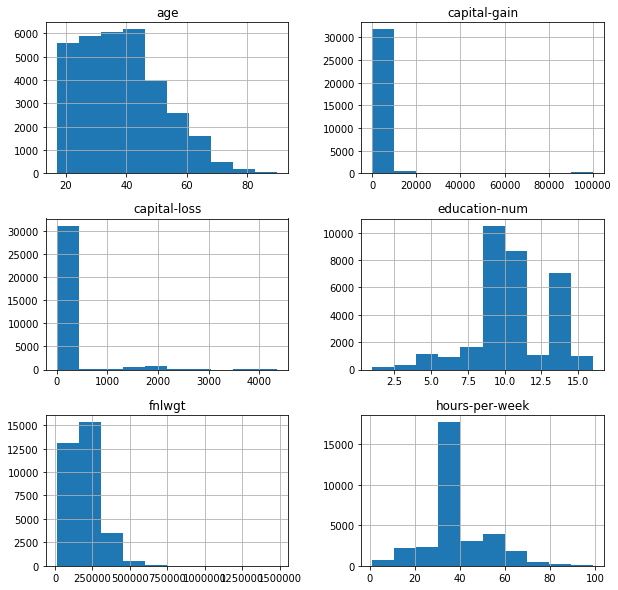

In [63]:
num_attributes.hist(figsize=(10,10))

In [64]:
train_data.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


Ни один из числовых значений не имеет пропущенных значений.

Значения в разных масштабах. Многие модели машинного обучения требуют, чтобы значения были в одном масштабе. Мы будем использовать StandardScaler из библиотеки sklearn для нормализации данных.

### Обработка категориальных столбцов

In [65]:
cat_attributes = train_data.select_dtypes(include='object')
print(cat_attributes.columns)

Index(['workClass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country', 'income'],
      dtype='object')


In [66]:
cat_attributes.head(3)

,workClass,education,marital-status,occupation,relationship,race,sex,native-country,income
0,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,<=50K
1,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,<=50K
2,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,<=50K


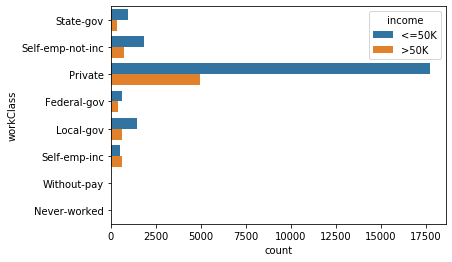

In [67]:
sns.countplot(y='workClass', hue='income', data = cat_attributes)

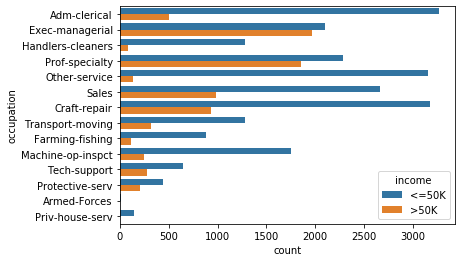

In [68]:
sns.countplot(y='occupation', hue='income', data = cat_attributes)

Выводы:
- Столбец education - это просто строковое представление столбца education-num. Удалим столбец education
- Переменные workClass, occupation, native-country имеют пропущенные значения. Мы заменим отсутствующие значения в каждом столбце на наиболее часто встречающееся значение этого столбца.

Нужно обработать числовые и категориальные значения по-разному. Числовые значения необходимо нормализироать, а категориальные значения нам нужно заполнить пропущенные значения и кодировать категориальные значения в числовые значения. 
Чтобы применить эту последовательность преобразований, мы будем использовать Pipeline class sklearn.

### Создание Pipelines

#### ColumnsSelector Pipeline

sklearn не предоставляет библиотеки для прямого манипулирования с датафреймом pandas.

In [69]:
class ColumnsSelector(BaseEstimator, TransformerMixin):
  
  def __init__(self, type):
    self.type = type
  
  def fit(self, X, y=None):
    return self
  
  def transform(self,X):
    return X.select_dtypes(include=[self.type])

#### Numerical Data Pipeline

Мы выбираем числовые атрибуты, используя  ColumnsSelector, определенный выше, а затем масштабируем значения, используя StandardScaler.

In [70]:
num_pipeline = Pipeline(steps=[
    ("num_attr_selector", ColumnsSelector(type='int64')),
    ("scaler", StandardScaler())
])

Если мы вызываем методы fit и transform для num_pipeline, он внутренне вызывает методы fit и transform для всех преобразователей, определенных в pipeline.

#### Категориальный конвейер данных

Нам нужно заменить отсутствующие значения в категориальных столбцах. Мы заменим пропущенные значения наиболее часто встречающимися значениями в каждом столбце. Напишем собственный трансформер, который будет принимать список столбцов, для которых нам нужно заменить пропущенные значения и стратегию, используемую для заполнения пропущенных значений.

In [71]:
class CategoricalImputer(BaseEstimator, TransformerMixin):
  
  def __init__(self, columns = None, strategy='most_frequent'):
    self.columns = columns
    self.strategy = strategy
    
    
  def fit(self,X, y=None):
    if self.columns is None:
      self.columns = X.columns
    
    if self.strategy is 'most_frequent':
      self.fill = {column: X[column].value_counts().index[0] for 
        column in self.columns}
    else:
      self.fill ={column: '0' for column in self.columns}
      
    return self
      
  def transform(self,X):
    X_copy = X.copy()
    for column in self.columns:
      X_copy[column] = X_copy[column].fillna(self.fill[column])
    return X_copy

Будем использовать pd.get_dummies для преобразования категориальных значений в числовые значения.

In [72]:
class CategoricalEncoder(BaseEstimator, TransformerMixin):
  
  def __init__(self, dropFirst=True):
    self.categories=dict()
    self.dropFirst=dropFirst
    
  def fit(self, X, y=None):
    join_df = pd.concat([train_data, test_data])
    join_df = join_df.select_dtypes(include=['object'])
    for column in join_df.columns:
      self.categories[column] = join_df[column].value_counts().index.tolist()
    return self
    
  def transform(self, X):
    X_copy = X.copy()
    X_copy = X_copy.select_dtypes(include=['object'])
    for column in X_copy.columns:
      X_copy[column] = X_copy[column].astype({column:
                CategoricalDtype(self.categories[column])})
    return pd.get_dummies(X_copy, drop_first=self.dropFirst)

#### Полный категориальный Pipeline

In [73]:
cat_pipeline = Pipeline(steps=[
    ("cat_attr_selector", ColumnsSelector(type='object')),
    ("cat_imputer", CategoricalImputer(columns=['workClass','occupation', 'native-country'])),
    ("encoder", CategoricalEncoder(dropFirst=True))
])

In [74]:
full_pipeline = FeatureUnion([("num_pipe", num_pipeline), 
                ("cat_pipeline", cat_pipeline)])

Отбросим столбцы, которые не нужны

In [75]:
train_data.drop(['fnlwgt', 'education'], axis=1, inplace=True)
test_data.drop(['fnlwgt', 'education'], axis=1, inplace=True)

## Training the model

создадим копию набора training dataset и разделим на векторы объектов и целевые значения.

In [76]:
train_copy = train_data.copy()
train_copy["income"] = train_copy["income"].apply(lambda x:0 if 
                        x=='<=50K' else 1)
X_train = train_copy.drop('income', axis =1)
Y_train = train_copy['income']

Передаем X_train к full_pipeline

In [77]:
X_train_processed = full_pipeline.fit_transform(X_train)

In [78]:
model = LogisticRegression(random_state=0)
model.fit(X_train_processed, Y_train)

C:\Users\BEST\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

### Testing the model

In [79]:
test_copy = test_data.copy()
test_copy["income"] = test_copy["income"].apply(lambda x:0 if 
                      x=='<=50K.' else 1)
X_test = test_copy.drop('income', axis =1)
Y_test = test_copy['income']

In [80]:
X_test_processed = full_pipeline.fit_transform(X_test)
predicted_classes = model.predict(X_test_processed)

### Оценка модели

In [81]:
accuracy_score(predicted_classes, Y_test.values)

0.8524660647380382

accuracy 85,2%

Text(33.0, 0.5, 'Actual classes')

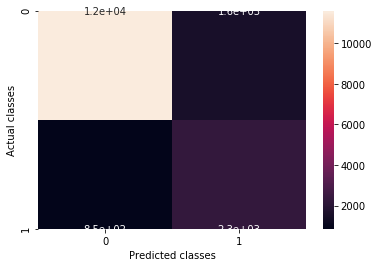

In [83]:
cfm = confusion_matrix(predicted_classes, Y_test.values)
sns.heatmap(cfm, annot=True)
plt.xlabel('Predicted classes')
plt.ylabel('Actual classes')

In [84]:
cfm 

array([[11583,  1550],
       [  852,  2296]], dtype=int64)